
### Costa Rica
Costa Rica is a Central American nation with a population of 4.9 Million population. It has been known for its stable democracy, in a region that has had some instability. As per a report by the National Statistics and Census Institute (INEC) in 2015, more than 1.1 million Costa Ricans lived in poverty, According to data from the National Household Survey of the National Institute of Statistics and Census, the percentage of poor households in Costa Rica went from 20.5  to 20 percent between 2016 and 2017, and extreme poverty dropped from 6.3 percent to 5.7 percent. 

### IDB 
Inter-American Development Bank (IDB) works in Latin America and the Caribbean region to improve the general life conditions of the population. financial and technical support for countries working to reduce poverty and inequality, they help improve health and education, and advance infrastructure.

### Proxy Means Testing 
In any social program, it is always tough to make sure that the aid goes to the deserving. The poorest segment of the population usually is unable to provide the necessary income and expense records to prove that they qualify. This is where proxy means testing (PMT) comes into the picture. The key idea  is to use observable characteristics of the household or the members to estimate their incomes or consumption, when other income data (salary slips, tax returns) are unavailable or sketchy. More details about PMT can be found in [this report](https://olc.worldbank.org/sites/default/files/1.pdf).

### About the competetion
This dataset provided by IADB has the 142 fields of labelled data for 2988 households in the training set and 7352 in the test set. Of these,  8% fall in the extremely poor category. The goal is to maximize the f1 score (harmonic mean of precision and recall) across all the categories. A generalized solution which can build on the above metrics would be helpful to IDB and other institutions working towards helping the economically weaker sections of the society.

![Costa Rica](https://raw.githubusercontent.com/InFoCusp/kaggle_images/master/costa_rica.jpg)

In [ ]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from matplotlib import pyplot as plt
from plotly import tools

In [ ]:
data_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

def print_numbers(df, category):
    print('%s Data containing %d fields provided for %d individuals of %d families'
          %(category, df.shape[1], df.shape[0], len(np.unique(df['idhogar']))))
    
print_numbers(data_df, 'Training')
print_numbers(test_df, 'Testing')

### Some samples from the data

It is important to note here that there are multiple entries - one for each member of the household and some of the fields common to all members of the household such as #rooms, material of the house, total members in the house, etc. can be eassily collapsed till we have one row per house.

In [ ]:
data_df.head()

### Missing values
Top fields with missing values: (Just 3 fields with majority of the data missing)
1. rez_esc, Years behind in school 
2. v18q1, number of tablets household owns
3. v2a1, Monthly rent payment

In [ ]:
topnan_train = data_df.isnull().sum().sort_values(0, ascending = False)/(data_df.shape[0])*100
print("Field Name   %NaN")
print(topnan_train.head())

In [ ]:
def remove_strings(val):
    """Converts strings to boolean values"""
    if not isinstance(val, str):
        return val
    if val.lower() == "yes":
        return 1
    else:
        return 0

In [ ]:
# Making data numerical for easier computations
# data_df['idhogar'] = data_df['idhogar'].apply(hash)         
data_df['dependency'] = data_df['dependency'].apply(remove_strings)
data_df['edjefe'] = data_df['edjefe'].apply(remove_strings)
data_df['edjefa'] = data_df['edjefa'].apply(remove_strings)

In [ ]:
# Deleting columns with very less data
drop_column_list = ['rez_esc', 'v18q1', 'v2a1']
data_df.drop(drop_column_list, axis=1, inplace=True)

# Deleting Id too, it is unique per row, hence not useful for classification
del data_df['Id']

# Dropping duplicate columns
data_df = data_df.T.drop_duplicates().T

# Replacing missing data with mean
data_df.fillna(data_df.mean(), inplace=True) 

In [ ]:
# Dictionary showing way(s) to aggregate each type of column
# We have taken mean for data that should be same across household (e.g bedrooms)
aggregation_dict = {'SQBage': ['mean'],
 'SQBdependency': ['mean'],
 'SQBedjefe': ['mean'],
 'SQBescolari': ['mean', 'sum'],
 'SQBhogar_nin': ['mean'],
 'SQBhogar_total': ['mean'],
 'SQBmeaned': ['mean'],
 'SQBovercrowding': ['mean'],
 'abastaguadentro': ['mean'],
 'abastaguafuera': ['mean'],
 'abastaguano': ['mean'],
 'age': ['mean', 'sum', 'min', 'max'],
 'agesq': ['mean'],
 'area1': ['mean'],
 'area2': ['mean'],
 'bedrooms': ['mean'],
 'cielorazo': ['mean'],
 'computer': ['mean'],
 'coopele': ['mean'],
 'dependency': ['mean'],
 'dis': ['sum'],
 'edjefa': ['mean'],
 'edjefe': ['mean'],
 'elimbasu1': ['mean'],
 'elimbasu2': ['mean'],
 'elimbasu3': ['mean'],
 'elimbasu4': ['mean'],
 'elimbasu5': ['mean'],
 'elimbasu6': ['mean'],
 'energcocinar1': ['mean'],
 'energcocinar2': ['mean'],
 'energcocinar3': ['mean'],
 'energcocinar4': ['mean'],
 'epared1': ['mean'],
 'epared2': ['mean'],
 'epared3': ['mean'],
 'escolari': ['mean', 'max', 'sum'],
 'estadocivil1': ['sum'],
 'estadocivil2': ['sum'],
 'estadocivil3': ['sum'],
 'estadocivil4': ['sum'],
 'estadocivil5': ['sum'],
 'estadocivil6': ['sum'],
 'estadocivil7': ['sum'],
 'etecho1': ['mean'],
 'etecho2': ['mean'],
 'etecho3': ['mean'],
 'eviv1': ['mean'],
 'eviv2': ['mean'],
 'eviv3': ['mean'],
 'female': ['sum'],
 'hacapo': ['mean'],
 'hacdor': ['mean'],
 'hhsize': ['mean'],
 'hogar_adul': ['mean'],
 'hogar_mayor': ['mean'],
 'hogar_nin': ['mean'],
 'hogar_total': ['mean'],
#  'idhogar': ['mean'],
 'instlevel1': ['mean', 'sum'],
 'instlevel2': ['mean', 'sum'],
 'instlevel3': ['mean', 'sum'],
 'instlevel4': ['mean', 'sum'],
 'instlevel5': ['mean', 'sum'],
 'instlevel6': ['mean', 'sum'],
 'instlevel7': ['mean', 'sum'],
 'instlevel8': ['mean', 'sum'],
 'instlevel9': ['mean', 'sum'],
 'lugar1': ['mean'],
 'lugar2': ['mean'],
 'lugar3': ['mean'],
 'lugar4': ['mean'],
 'lugar5': ['mean'],
 'lugar6': ['mean'],
 'male': ['sum'],
 'meaneduc': ['mean'],
 'mobilephone': ['mean'],
 'noelec': ['mean'],
 'overcrowding': ['mean'],
 'paredblolad': ['mean'],
 'pareddes': ['mean'],
 'paredfibras': ['mean'],
 'paredmad': ['mean'],
 'paredother': ['mean'],
 'paredpreb': ['mean'],
 'paredzinc': ['mean'],
 'paredzocalo': ['mean'],
 'parentesco1': ['sum'],
 'parentesco10': ['sum'],
 'parentesco11': ['sum'],
 'parentesco12': ['sum'],
 'parentesco2': ['sum'],
 'parentesco3': ['sum'],
 'parentesco4': ['sum'],
 'parentesco5': ['sum'],
 'parentesco6': ['sum'],
 'parentesco7': ['sum'],
 'parentesco8': ['sum'],
 'parentesco9': ['sum'],
 'pisocemento': ['mean'],
 'pisomadera': ['mean'],
 'pisomoscer': ['mean'],
 'pisonatur': ['mean'],
 'pisonotiene': ['mean'],
 'pisoother': ['mean'],
 'planpri': ['mean'],
 'public': ['mean'],
 'qmobilephone': ['mean'],
 'r4h1': ['mean'],
 'r4h2': ['mean'],
 'r4h3': ['mean'],
 'r4m1': ['mean'],
 'r4m2': ['mean'],
 'r4m3': ['mean'],
 'r4t1': ['mean'],
 'r4t2': ['mean'],
 'r4t3': ['mean'],
 'refrig': ['mean'],
 'rooms': ['mean'],
 'sanitario1': ['mean'],
 'sanitario2': ['mean'],
 'sanitario3': ['mean'],
 'sanitario5': ['mean'],
 'sanitario6': ['mean'],
 'tamhog': ['mean'],
 'tamviv': ['mean'],
 'Target': ['max'],
 'techocane': ['mean'],
 'techoentrepiso': ['mean'],
 'techootro': ['mean'],
 'techozinc': ['mean'],
 'television': ['mean'],
 'tipovivi1': ['mean'],
 'tipovivi2': ['mean'],
 'tipovivi3': ['mean'],
 'tipovivi4': ['mean'],
 'tipovivi5': ['mean'],
 'v14a': ['mean'],
 'v18q': ['mean'],
                   }

pop_list = list( set(aggregation_dict.keys()) - set(data_df.columns)) 

for key in pop_list:
    aggregation_dict.pop(key)

In [ ]:
# Cross checking assumption of same data across household (where we are taking mean).
#NoAssumptions #WeBelieveInCrossChecking #Hash
for column_name, agg in aggregation_dict.items():
    if 'mean' in agg:
        s1 = data_df.groupby(['idhogar', column_name])
        s2 = data_df.groupby(['idhogar'])
        
        if len(s1)!=len(s2):
            print (column_name, len(s1), len(s2))

# All the households were expected to have different values for all the ones printed below.

# Uniting the families

### Family is not an important thing. It's everything. -Michael J Fox
#RandomInternetQuote

In [ ]:
family_data_df = data_df.groupby('idhogar', as_index=True).agg(aggregation_dict).reset_index()
print ("Length of new dataframe(number of families): " + str(len(family_data_df)))
family_data_df.columns = ["_".join(x) for x in family_data_df.columns.ravel()]
family_data_df.head()

In [ ]:
target_sizes = data_df.groupby('Target').size()

poverty_levels_dict = {'1': 'extreme poverty' ,'2':'moderate poverty' ,
'3' : 'vulnerable households', '4': 'non vulnerable households'}
groups = target_sizes.index.values.astype(str)
labels  = [poverty_levels_dict[group] for group in groups]

fig = {
  "data": [
    {
      "values": target_sizes.values,
      "labels": labels,
      #"domain": {"x": [0, .48]},
      "name": "GHG Emissions",
      "hoverinfo":"label+percent+name",
        "textfont": dict(size=12),
      "type": "pie"
    },
    ],
       'layout': {'title': 'Distribution of different poverty classes'}
}
iplot(fig, filename='donut')

In [ ]:
target_sizes.values

In [ ]:
grouped_houses_data = data_df.groupby('idhogar', as_index=False)


fig = {
    'data': [
        {
            'labels': ["Households who doesn't have a tablet", "Households who have a tablet"],
            'values': (grouped_houses_data['v18q'].mean())['v18q'].value_counts().sort_index(),
            'type': 'pie',
            'hole': 0.45,
            'domain': {'x': [0, .33],
                      'y': [0, .5]},
            'hoverinfo':'label+percent+name',
            'textinfo':'none'
        },
        {
            'labels': ["Households who doesn't have a refrigerator", "Households who have a refrigerator"],
            'values': (grouped_houses_data['refrig'].mean())['refrig'].value_counts().sort_index(),
            'type': 'pie',
            'hole': 0.45,
            'domain': {'x': [.34, 0.66],
                       'y': [0, .5]},
            'hoverinfo':'label+percent+name',
            'textinfo':'none'

        },
        {
            'labels': ["Households who doesn't have a toilet", "Households who have a toilet"],
            'values': (grouped_houses_data['v14a'].mean())['v14a'].value_counts().sort_index(),
            'type': 'pie',
            'hole': 0.45,
            'domain': {'x': [0.67, 1],
                       'y': [0, 0.5]},
            'hoverinfo':'label+percent+name',
            'textinfo':'none'
        },
        {
            'labels': ["Households who doesn't have a television", "Households who have a television"],
            'values': (grouped_houses_data['television'].mean())['television'].value_counts().sort_index(),
            'type': 'pie',
            'hole': 0.45,
            'domain': {'x': [0, 0.33],
                       'y': [.51, 1]},
            'hoverinfo':'label+percent+name',
            'textinfo':'none'
        },
        {
            'labels': ["Households who doesn't have a computer", "Households who have a computer"],
            'values': (grouped_houses_data['computer'].mean())['computer'].value_counts().sort_index(),
            'type': 'pie',
            'hole': 0.45,
            'domain': {'x': [.34, 0.66],
                       'y': [.51, 1]},
            'hoverinfo':'label+percent+name',
            'textinfo':'none'
        },
        {
            'labels': ["Households who doesn't have a mobilephone", "Households who have a mobilephone"],
            'values': (grouped_houses_data['mobilephone'].mean())['mobilephone'].value_counts().sort_index(),
            'type': 'pie',
            'hole': 0.45,
            'domain': {'x': [.67, 1],
                       'y': [.51, 1]},
            'hoverinfo':'label+percent+name',
            'textinfo':'none'
        }
    ],
    'layout': {'title': 'Households having different amenties or not',
               'annotations': [{'text': 'Television', 'showarrow': False, 'x': 0.125, 'y': 0.77, 'font': {'size': 16}},
                               {'text': 'Computer', 'showarrow': False, 'x': 0.5, 'y': 0.77, 'font': {'size': 16}},
                               {'text': 'Mobilephone', 'showarrow': False, 'x': 0.9, 'y': 0.77, 'font': {'size': 16}},
                               {'text': 'Tablet', 'showarrow': False, 'x': 0.13, 'y': 0.23, 'font': {'size': 16}},
                               {'text': 'Refrigerator', 'showarrow': False, 'x': 0.5, 'y': 0.23, 'font': {'size': 16}},
                               {'text': 'Toilet', 'showarrow': False, 'x': 0.865, 'y': 0.23, 'font': {'size': 16}}
                              ], 
               'showlegend': False,
               'width': 1000,
               'height':1000}
}


iplot(fig)

In [ ]:
fig = tools.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=['Bedrooms','Rooms', 'Total household Members', '# Persons Per Room'])

x = (grouped_houses_data['bedrooms'].mean())['bedrooms']
tr1 = go.Histogram(x = x, showlegend=True)
fig.append_trace(tr1,1,1)


x = (grouped_houses_data['rooms'].mean())['rooms']
tr1 = go.Histogram(x = x, showlegend=True)
fig.append_trace(tr1,1,2)

x = (grouped_houses_data['tamhog'].mean())['tamhog']
tr1 = go.Histogram(x = x, showlegend=True)
fig.append_trace(tr1,2,1)

x = (grouped_houses_data['overcrowding'].mean())['overcrowding']
tr1 = go.Histogram(x = x, showlegend=True)
fig.append_trace(tr1,2,2)

fig['layout'].update(height=900, title="Household Members/ rooms", barmode="stack", showlegend=False)
iplot(fig)

In [ ]:
grouped_houses_data.apply(np.mean)

In [ ]:
region_fields = ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']
labels  = ['Central', 'Chorotega', 'Pacifico central', 'Brunca', 'Huetar Atlantica', 'Huetar Norte']
fig = {
    'data':[{
        'values': (grouped_houses_data[region_fields].mean())[region_fields].sum().values,
        'labels': labels,
        'name': 'Regions',
        'hoverinfo': 'label+percent+name',
        'textfont': dict(size=12),
        'type': 'pie'
    }],
    'layout': {
        'title': 'Distributions of household in different regions'
    }
}

iplot(fig)

In [ ]:
fig = {
    'data':[{
        'values': (grouped_houses_data['area1'].mean())['area1'].value_counts().sort_index(),
        'labels': ["Households in rural area", "Households in urban area"],
        'name': 'Regions',
        'hoverinfo': 'label+percent+name',
        'textfont': dict(size=12),
        'type': 'pie'
    }],
    'layout': {
        'title': 'Distributions of household in rural/ urban regions'
    }
}

iplot(fig)

Work in progress, more cool stuff coming up soon.. 
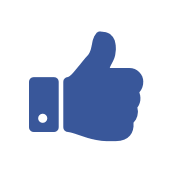 <b>Please leave an upvote if you found the notebook to be useful. </b> <br/>